## 🏈 Hit 'Em In Stride
Why minimizing route disruption matters for passing play success!


## 📘 Introduction and Motivation

In today's NFL, explosive plays often depend on a quarterback’s ability to deliver the ball to their targeted receiver in-stride, allowing the receiver to maintain their momentum while the ball is in the air all the way through the catch point. Watching an NFL game, you'll often hear announcers emphasize a quarterback's ability to "throw a receiver open" or "put the ball on a receiver's body". Despite the importance of timing and ball placement, our group has never seen these quantified on a broadcast or displayed with a metric.

In this analysis, we introduce an in-stride metric that evaluates how well quarterbacks are able minimize route disruption to the receiver from the moment the ball is thrown to the moment it arrives. We focus mainly on the idea of acceleration and how much a receiver is speeding up or slowing down the moments before and after the ball is thrown. 

This idea is derived from the frame-by-frame tracking movement provided in the competitaion. Plays in which receivers are able maintain a relatively consistent acceleration will be considered to be “in-stride” receptions, with the idea that they reflect good quarterback ball placement and timing with their intended target.

Our goals in this notebook are as follows:
1. Quantify receiver disruption using acceleration changes within routes.
2. Explore whether reduced disruption leads to better play outcomes, such as an increase in yards gained or higher EPA.
3. Aggregate the disruptions to the quarterback level to identify which QBs are best at sustaining wide receiver momentum.

## 📦 Data Description and Preparation

This notebook relies on all three components of the NFL Big Data Bowl 2026 data that covers Weeks 1 to 18 of the 2023 season. The first component is the input  data, which contains frame-by-frame player movement information before the ball is thrown. These files also include identifiers such as game ID, play ID, and frame ID, along with each player’s NFL ID, position, name, and role on the specific play. The input data also has field coordinates (x and y) and several motion variables, including speed, acceleration, and directional orientation. The second component is the output data, which captures player movement after the ball is released. These files also include the key identifiers and field coordinates, but do not provide speed, acceleration, or direction. In this notebook, those values must are reconstructed directly from the positional changes across frames. Lastly, the supplementary dataset provides play-level context and outcomes, including yards gained, pass result, expected points added, and defensive coverage information. Because the tracking data is recorded at 10 frames per second across every play, the input, output, and supplementary files can be consistently merged on game ID, play ID, and player ID.

Data preparation involved loading the R libraries (tidyverse, data.table, and zoo) and establishing Kaggle directory paths to access the competition data. To process the full season, we created a helper function that locates and loads all 18 weekly input and output files, binding them into a single, season-long table for each. The supplementary file was then loaded and all identifiers were standardized to integer format to ensure clean joins down the line. From the input table, we identified targeted receivers using player roles, which allowed us to isolate the players whose pre- and post-throw movements are needed to analyze in-stride performance. With all the datasets cleaned, filtered, and merged, we prepared final computation-ready tables for computing speed and acceleration. This data preprocessing established a consistent and reliable foundation for measuring the in-stride metric introduced in the following section.


In [1]:
# ============================
# Load packages (if necessary)
# ============================


#install.packages("zoo")
#install.packages("ggrepel")
#install.packages("gt")
#install.packages("magick", repos = "https://cloud.r-project.org/")
#install.packages("IRdisplay")

In [2]:
# ============================
# Load libraries and establish path
# ============================

library(tidyverse)
library(data.table)
library(zoo)
library(ggrepel)
library(htmltools)
library(IRdisplay)
library(gt)
library(magick)
library(IRdisplay)

# Root Directory
root <- "/kaggle/input/nfl-big-data-bowl-2026-analytics"

# Access folder and establish training data directory
data_dir  <- file.path(root, "114239_nfl_competition_files_published_analytics_final")
train_dir <- file.path(data_dir, "train")

# Sanity checks
print("Files and folders under data_dir:")
print(list.files(data_dir))

print("First 10 files under train_dir:")
print(head(list.files(train_dir), 10))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘data.table’




The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year




The following objects are masked from ‘package:dplyr’:

    between, first, last




The following object is masked from ‘package:purrr’:

    transpose





Attaching package: ‘zoo’




The following objects are masked from ‘package:data.table’:

    yearmon, yearqtr




The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Linking to ImageMagick 6.9.11.60
Enabled features: fontconfig, freetype, fftw, heic, lcms, pango, webp, x11
Disabled features: cairo, ghostscript, raw, rsvg



Using 4 threads



[1] "Files and folders under data_dir:"


[1] "supplementary_data.csv" "train"                 


[1] "First 10 files under train_dir:"


 [1] "input_2023_w01.csv" "input_2023_w02.csv" "input_2023_w03.csv"
 [4] "input_2023_w04.csv" "input_2023_w05.csv" "input_2023_w06.csv"
 [7] "input_2023_w07.csv" "input_2023_w08.csv" "input_2023_w09.csv"
[10] "input_2023_w10.csv"


In [3]:
# ============================
# Create helper to load all weeks with a "input" or "output" prefixes
# ============================

load_weeks <- function(prefix) {
  files <- list.files(
    train_dir,
    pattern    = paste0("^", prefix, "_2023_w[0-9]{2}\\.csv$"),
    full.names = TRUE
  )
  
  stopifnot(length(files) > 0)
  
  dt_list <- lapply(files, fread)
  dt <- rbindlist(dt_list, use.names = TRUE, fill = TRUE)
  
  key_cols <- intersect(c("game_id","play_id","nfl_id","frame_id"), names(dt))
  if (length(key_cols) > 0) {
    dt[, (key_cols) := lapply(.SD, as.integer), .SDcols = key_cols]
  }
  
  as_tibble(dt)
}

In [4]:
# ============================
# Create dataframes
# ============================

df_input  <- load_weeks("input")
df_output <- load_weeks("output")

# Supplementary play-level data
df_supp <- fread(file.path(data_dir, "supplementary_data.csv")) |>
  as_tibble() |>
  mutate(
    game_id = as.integer(game_id),
    play_id = as.integer(play_id)
  )

cat("Input rows:", nrow(df_input), "\n")
cat("Output rows:", nrow(df_output), "\n")
cat("Supplementary rows:", nrow(df_supp), "\n\n")

Input rows: 4880579 


Output rows: 562936 


Supplementary rows: 18009 



In [5]:
# ============================
# Determine roles within a play to filter for targeted receivers
# ============================

roles <- df_input |>
  distinct(
    game_id, play_id, nfl_id,
    player_side, player_role, player_position, player_name
  )

targeted <- roles |>
  filter(player_side == "Offense", player_role == "Targeted Receiver") |>
  distinct(game_id, play_id, nfl_id)

cat("Distinct targeted receivers by game,play,and player:", nrow(targeted), "\n\n")

Distinct targeted receivers by game,play,and player: 14108 



In [6]:
# ============================
# Compute Speed and Acceleration from Input and Output
# ============================

# Function that calculates receiver motion (direction, speed, acceleration)
compute_motion_metrics <- function(df) {
  dt <- as.data.table(df)
  setorder(dt, game_id, play_id, nfl_id, frame_id)

  dt[, `:=`(
    x_prev = shift(x),
    y_prev = shift(y)
  ), by = .(game_id, play_id, nfl_id)]

  dt[, `:=`(
    dist = sqrt((x - x_prev)^2 + (y - y_prev)^2),
    dx = x - x_prev, # find change in x position
    dy = y - y_prev  # find change in y position
  )]
  
  dt[, `:=`(
    speed = dist / 0.1, # find player speed
    dir_calc = (atan2(dy, dx) * 180 / pi) %% 360 # find player direction
  )]
  
  dt[, speed_prev := shift(speed), by = .(game_id, play_id, nfl_id)]
  dt[, accel := (speed - speed_prev) / 0.1] # find player acceleration
  dt[, accel_smooth := (shift(accel) + accel + shift(accel, type = "lead")) / 3, 
     by = .(game_id, play_id, nfl_id)] # use last three frames to smooth out the acceleration calculation
  
  as.data.frame(dt)
}

input_motion  <- compute_motion_metrics(df_input)
output_motion <- compute_motion_metrics(df_output)

## 🔧 Methods and Metric Definition

Our next objective was to construct a measure to quantify how much a receiver’s momentum is affected right before and right after the throw. We started by developing a disruption metric, that quantifies the degree to which acceleration changes before and after the ball is released.

To compute disruption, we first restricted the tracking data to only targeted receivers, since they are the players directly responsible for catching the pass and are the center of our analysis for timing and ball placement. Additionally, we decided to filter out incompletions, because we wanted to see how disruption was correlated with big plays and not be thrown off by a large number of plays where the yards gained is zero. Lastly, we filtered only for throws over 15 yards, because we felt this gave necessary reaction time to receivers to meaningully speed up or slow down. For each targeted player, we took a one-second window before the throw (the final 10 input frames) and a one-second window after the throw (the first 10 output frames). The pre-throw acceleration was defined as the mean of the final 10 smoothed acceleration values prior to release, and the post-throw acceleration was the mean of the first 10 values after release. We then computed disruption as the difference between these two. A positive disruption indicates increased acceleration directly after the ball was released, while a negative disruption indicates slowing down or hesitating. We also caclulated the absolute value of disruption to capture the magnitude of adjustment regardless of the direction it happened in.

Once disruption was calculated, we joined these play-level metrics to the supplementary dataset to incorporate play outcomes like as yards gained, pass result, and expected points added. This allowed us to examine how acceleration changes relate to actual on-field performance. We then produced an exploratory visualization plotting receiver disruption versus yards gained.

In [7]:
# ============================
# Calculate pre- and post-throw disruption
# ============================

# Restrict motion data to targeted receivers
input_tr  <- input_motion  |>
  semi_join(targeted, by = c("game_id","play_id","nfl_id"))

output_tr <- output_motion |>
  semi_join(targeted, by = c("game_id","play_id","nfl_id"))

# Pre-throw window: last 10 frames before the throw
pre_window <- input_tr |>
  group_by(game_id, play_id, nfl_id) |>
  slice_max(frame_id, n = 10, with_ties = FALSE)

pre_summ <- pre_window |>
  summarise(
    mean_accel_pre = mean(accel_smooth, na.rm = TRUE),
    .groups = "drop"
  )

# Post-throw window: first 10 frames after the throw (output side)
post_window <- output_tr |>
  group_by(game_id, play_id, nfl_id) |>
  slice_min(frame_id, n = 10, with_ties = FALSE)

post_summ <- post_window |>
  summarise(
    mean_accel_post = mean(accel_smooth, na.rm = TRUE),
    .groups = "drop"
  )

# Combine and compute disruption
disruption_df <- pre_summ |>
  inner_join(post_summ, by = c("game_id","play_id","nfl_id")) |>
  mutate(
    # How much acceleration changes after the throw
    disruption = mean_accel_post - mean_accel_pre,
    # Absolute value of disruption for magnitude
    disruption_abs = abs(disruption)
  )

cat(
  "Rows with disruption calculated (targeted receivers with both pre- and post-throw windows):",
  nrow(disruption_df), "\n\n"
)

Rows with disruption calculated (targeted receivers with both pre- and post-throw windows): 14108 



In [8]:
# ============================
# Join play outcomes and define disruption-based in-stride window
# ============================

# Join disruption metrics to play outcomes
stride_play_df <- disruption_df |>
  inner_join(
    df_supp |>
      select(game_id, play_id, pass_result, yards_gained, expected_points_added, pass_length),
    by = c("game_id","play_id")
  ) |>
  drop_na(disruption, disruption_abs)

cat("Rows with disruption and outcomes:", nrow(stride_play_df), "\n")

# Focus on completed passes for in-stride analysis
stride_complete <- stride_play_df |>
  filter(pass_result == "C") |>
  filter(pass_length >= 15) |>
  drop_na(yards_gained)

cat("Completed passes over 20 air yards with disruption info:", nrow(stride_complete), "\n\n")

Rows with disruption and outcomes: 14108 


Completed passes over 20 air yards with disruption info: 1536 



In [9]:
# ============================
# Calculate Yards After Catch (YAC)
# ============================

# Step 1: Get the catch position (x coordinate at last frame of output for targeted receiver)
catch_positions <- output_tr |>
  group_by(game_id, play_id, nfl_id) |>
  slice_max(frame_id, n = 1, with_ties = FALSE) |>
  ungroup() |>
  select(game_id, play_id, nfl_id, catch_x = x)

# Step 2: Get line of scrimmage information and play direction from supplementary data
los_info <- df_supp |>
  select(game_id, play_id, yardline_side, yardline_number, yards_gained, possession_team) |>
  inner_join(
    df_input |>
      distinct(game_id, play_id, play_direction, absolute_yardline_number),
    by = c("game_id", "play_id")
  )

# Step 3: Calculate absolute line of scrimmage position
# The x coordinate system: 0 = back of home endzone, 10 = home goal line,
# 60 = 50 yard line, 110 = away goal line, 120 = back of away endzone
los_info <- los_info |>
  mutate(
    # Convert yardline_number to absolute field position
    los_absolute_x = case_when(
      # If yardline_side matches possession team, they're on their own side
      yardline_side == possession_team & play_direction == "right" ~ 10 + yardline_number,
      yardline_side == possession_team & play_direction == "left" ~ 10 + (100 - yardline_number),
      # If yardline_side doesn't match possession team, they're on opponent's side
      yardline_side != possession_team & play_direction == "right" ~ 10 + (100 - yardline_number),
      yardline_side != possession_team & play_direction == "left" ~ 10 + yardline_number,
      TRUE ~ NA_real_
    ),
    # Calculate final yardline position (where play ended)
    final_position_x = case_when(
      play_direction == "right" ~ los_absolute_x + yards_gained,
      play_direction == "left" ~ los_absolute_x - yards_gained,
      TRUE ~ NA_real_
    )
  )

# Step 4: Join everything together and calculate YAC
stride_complete_with_yac <- stride_complete |>
  inner_join(catch_positions, by = c("game_id", "play_id", "nfl_id")) |>
  inner_join(
    los_info |> select(game_id, play_id, play_direction, los_absolute_x, final_position_x),
    by = c("game_id", "play_id")
  ) |>
  mutate(
    # Catch position is already in absolute coordinates
    catch_absolute_x = catch_x,

    # Calculate air yards (distance from LOS to catch point)
    air_yards = case_when(
      play_direction == "right" ~ catch_absolute_x - los_absolute_x,
      play_direction == "left" ~ los_absolute_x - catch_absolute_x,
      TRUE ~ NA_real_
    ),

    # Calculate YAC (distance from catch point to final position)
    yards_after_catch = case_when(
      play_direction == "right" ~ final_position_x - catch_absolute_x,
      play_direction == "left" ~ catch_absolute_x - final_position_x,
      TRUE ~ NA_real_
    )
  )

# Replace the original stride_complete with the version that has YAC
stride_complete <- stride_complete_with_yac

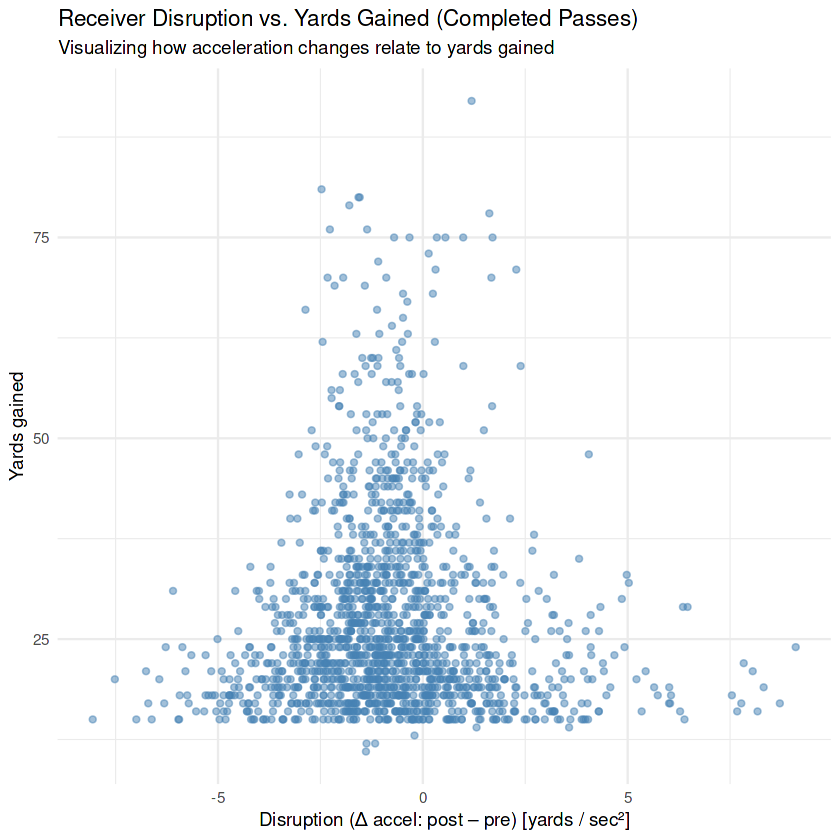

In [10]:
# ============================
# Disruption vs. Yards Gained (Completed Passes)
# ============================

ggplot(stride_complete,
       aes(x = disruption,
           y = yards_gained)) +
  geom_point(alpha = 0.5, size = 1.3, colour = "steelblue") +
  labs(
    title = "Receiver Disruption vs. Yards Gained (Completed Passes)",
    subtitle = "Visualizing how acceleration changes relate to yards gained",
    x = "Disruption (Δ accel: post – pre) [yards / sec²]",
    y = "Yards gained"
  ) +
  theme_minimal()

When examining the visualization of receiver disruption versus yards gained, we observed a consistent pattern: nearly all explosive passing plays clustered around acceleration changes between –2 and +2 yards/sec². Big plays rarely occurred when receivers experienced large positive or negative shifts in acceleration after the ball left the quarterback’s hand. This suggests that the most successful plays occur when receivers are able to maintain momentum, rather than needing to accelerate or decelerate when adjusting to the throw.

Using this insight, we defined an "in-stride" passing play as any play where the absolute acceleration change fell between –2 and +2 yards/sec². However, because a large amount of plays naturally fell within this range, we did not want to assume it was meaningful without any validation. To check this, we constructed the below big-play rate visualization, comparing explosive gains (≥ 25 yards) for plays inside and outside this in-stride window. The results showed a clear difference in outcomes: 13.89% of in-stride plays resulted in big gains, compared with only 5.45% of plays outside the window. This separation confirmed that low-disruption plays—where the receiver is able to stay in stride are genuinely linked to higher passing success, supporting the use of this threshold as the foundation of our in-stride metric.

In [11]:
# ============================
# Define in-stride window using disruption_abs only
# ============================

stride_complete <- stride_complete |>
  mutate(
    in_stride_window = if_else(
      disruption_abs <= 2,
      "In-stride",
      "All other plays"
    ),
    big_play = yards_gained >= 25
  )

cat("In-stride vs other play counts:\n")
print(table(stride_complete$in_stride_window))

In-stride vs other play counts:



All other plays       In-stride 
            492            1044 


In [12]:
# ============================
# Big Play Rate by Disruption Window
# ============================

# Count total plays in each window
total_counts <- stride_complete %>%
  count(in_stride_window, name = "total_plays")

# Count big plays (≥ 25 yards) in each window
big_counts <- stride_complete %>%
  filter(big_play) %>%
  count(in_stride_window, name = "big_plays")

# Combine and compute big play rate
summary_tbl <- total_counts %>%
  left_join(big_counts, by = "in_stride_window") %>%
  mutate(
    big_plays         = replace_na(big_plays, 0L),
    big_play_rate     = big_plays / total_plays,
    big_play_rate_pct = big_play_rate * 100
  )

print(summary_tbl)

# A tibble: 2 × 5
  in_stride_window total_plays big_plays big_play_rate big_play_rate_pct
  <chr>                  <int>     <int>         <dbl>             <dbl>
1 All other plays          492       168         0.341              34.1
2 In-stride               1044       545         0.522              52.2


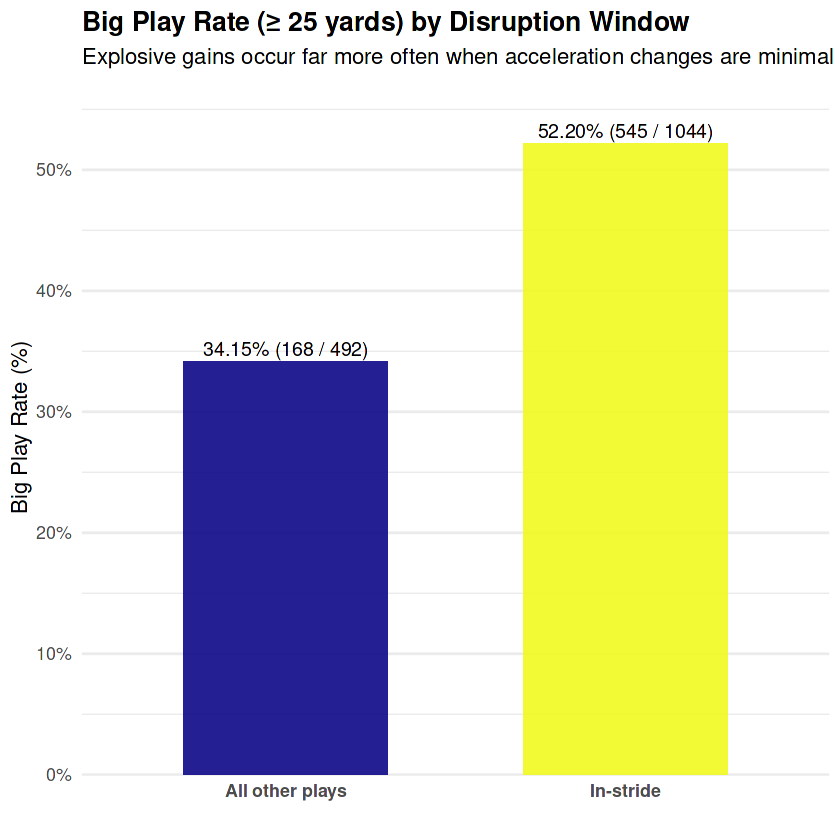

In [13]:
# ============================
# Bar Chart — Big Play Rate by Disruption Window
# ============================

ggplot(summary_tbl,
       aes(x = in_stride_window,
           y = big_play_rate_pct,
           fill = in_stride_window)) +
  
  geom_col(width = 0.6, alpha = 0.9) +
  
  # Label with percent and counts
  geom_text(
    aes(label = paste0(
      sprintf("%.2f%%", big_play_rate_pct),
      " (", big_plays, " / ", total_plays, ")"
    )),
    vjust = -0.4,
    size = 4
  ) +
  
  scale_fill_viridis_d(option = "plasma") +
  
  labs(
    title = "Big Play Rate (≥ 25 yards) by Disruption Window",
    subtitle = "Explosive gains occur far more often when acceleration changes are minimal",
    x = "",
    y = "Big Play Rate (%)",
    fill = ""
  ) +
  
  theme_minimal(base_size = 13) +
  theme(
    legend.position = "none",
    plot.title = element_text(face = "bold"),
    axis.text.x = element_text(face = "bold"),
    panel.grid.major.x = element_blank()
  ) +
  
  scale_y_continuous(
    labels = function(x) paste0(x, "%"),
    expand = expansion(mult = c(0, 0.10))
  )

In [14]:
# ============================
# Building explosive plays dataframe (>= 40 Yards)
# ============================

explosive_counts <- stride_complete %>%
  mutate(disruption_bin = case_when(
    disruption < -2             ~ "Deceleration Disruption",
    disruption >= -2 & disruption <=2 ~ "In-Stride",
    disruption > 2              ~ "Acceleration Disruption"
  )) %>%
  group_by(disruption_bin) %>%
  rename('Level of Route Disruption' = disruption_bin) %>%
  summarise(
    `Total Plays`      = n(),
    `Explosive Plays (>= 40 yds)` = sum(yards_gained >= 40, na.rm = TRUE),
    `Explosive Rate (%)` = mean(yards_gained >= 40, na.rm = TRUE) * 100,
    .groups = "drop"
  )

The following chart further emphasizes the importance of hitting the receiver in-stride when looking at explosive plays (defined to result in a gain of at least 40 yards). **16.9% of in-stride completions** resulted in a gain of 40+ yards (176 plays), while **only 7.5% of other completions** (37 plays) resulted in an explosive play.

In [15]:
# ============================
# Table of explosive plays by disruption
# ============================

# Well formatted table using gt()
explosive_table <- explosive_counts %>%
  gt() %>%
  tab_header(
    title = "Explosive Plays by Disruption Level"
  ) %>%
  # Table formatting
  fmt_number(columns = c(`Explosive Rate (%)`), decimals = 1) %>%
  tab_style(
    style = cell_text(weight = "bold", color = "darkblue"),
    locations = cells_body(
      columns = c(`Explosive Plays (>= 40 yds)`),
      rows = `Level of Route Disruption` == "In Stride"
    )
  ) %>%
  data_color(
    # Color emphasis on rows with more explosive plays
    columns = c(`Explosive Plays (>= 40 yds)`),
    fn = scales::col_numeric(
      palette = c("white", "tomato"),
      domain = NULL
    )
  )

# --- Inline render in Kaggle notebook ---
display_html(as_raw_html(explosive_table))

# --- Save to file for download/viewing ---
gtsave(explosive_table, "explosive_table.html")

"= 40 yds)"" class=""gt_row gt_right"" style=""border-style: none; padding-top: 8px; padding-bottom: 8px; padding-left: 5px; padding-right: 5px; margin: 10px; border-top-style: solid; border-top-width: 1px; border-top-color: #D3D3D3; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: middle; overflow-x: hidden; text-align: right; font-variant-numeric: tabular-nums; background-color: #FFFFFF; color: #000000;"" bgcolor=""#FFFFFF"" valign=""middle"" align=""right"">4"
"= 40 yds)"" class=""gt_row gt_right"" style=""border-style: none; padding-top: 8px; padding-bottom: 8px; padding-left: 5px; padding-right: 5px; margin: 10px; border-top-style: solid; border-top-width: 1px; border-top-color: #D3D3D3; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: middle; overflow-x: hidden; text-align: right; font-variant-numeric: tabular-nums; background-color: #FFE6DE; color: #000000;"" bgcolor=""#FFE6DE"" valign=""middle"" align=""right"">33"
"= 40 yds)"" class=""gt_row gt_right"" style=""border-style: none; padding-top: 8px; padding-bottom: 8px; padding-left: 5px; padding-right: 5px; margin: 10px; border-top-style: solid; border-top-width: 1px; border-top-color: #D3D3D3; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: middle; overflow-x: hidden; text-align: right; font-variant-numeric: tabular-nums; background-color: #FF6347; color: #FFFFFF;"" bgcolor=""#FF6347"" valign=""middle"" align=""right"">176"


## 📊 Results and Interpretations

After establishing that hitting receivers in stride was strongly associated with explosive passing plays, we wanted to lead off our results by understanding how our disruption metric relates to play success more broadly. To do this, we took a look at the statistical correlation between disruption_abs (our absolute value measure of how smoothly a receiver transitions from pre-throw to post-throw acceleration) and two different play-level outcomes, yards gained and expected points added (EPA).

For completed passes across all 18 weeks, we computed the Pearson correlation coefficients and corresponding p-values. This allowed us to quantify whether minimizing acceleration disruption is more of a “big play” phenomenon or whether it has a more general relationship with overall passing efficiency.

In [16]:
# ============================
# Correlation: Disruption vs Yards Gained
# ============================

# Must filter completed passes with valid yards + disruption
corr_df_yards <- stride_complete %>%
  drop_na(yards_gained, disruption_abs)

# Pearson correlation and p-value
corr_test_yards <- cor.test(corr_df_yards$disruption_abs,
                            corr_df_yards$yards_gained,
                            method = "pearson")

corr_test_yards


	Pearson's product-moment correlation

data:  corr_df_yards$disruption_abs and corr_df_yards$yards_gained
t = -8.8278, df = 1534, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2669574 -0.1717488
sample estimates:
       cor 
-0.2198766 


In [17]:
# ============================
# Correlation: Disruption vs EPA
# ============================

corr_df_epa <- stride_complete %>%
  drop_na(disruption_abs, expected_points_added)

corr_test_epa <- cor.test(
  corr_df_epa$disruption_abs,
  corr_df_epa$expected_points_added,
  method = "pearson"
)

corr_test_epa


	Pearson's product-moment correlation

data:  corr_df_epa$disruption_abs and corr_df_epa$expected_points_added
t = -6.048, df = 1534, p-value = 1.839e-09
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2010906 -0.1033814
sample estimates:
       cor 
-0.1526089 


For both Yards Gained and EPA we derived that there is a relatively small but highly significant correlation, that indicates that as disruption inscreases, plays tend to gain fewer yards and are less efficient. This reinforced our idea that quarterback ball placement matters deeply, becasue when the receivers can continue their acceleration pattern with minimal disruption, the offense performs better—both in explosive plays and overall efficiency. From here, we wanted to determine which quarterbacks were best at minimizing disruption.

In [18]:
# ============================
# Identify passers from roles table
# ============================

qb_roles <- roles %>%
  filter(player_role == "Passer", player_side == "Offense") %>%
  select(game_id, play_id, qb_id = nfl_id, qb_name = player_name) %>%
  distinct()

#head(qb_roles)

In [19]:
stride_qb <- stride_complete %>%
  inner_join(qb_roles, by = c("game_id", "play_id")) %>%
  drop_na(disruption_abs)

cat("Rows with QB + disruption info:", nrow(stride_qb), "\n")

Rows with QB + disruption info: 1535 


In [20]:
# ============================
# QB-level disruption vs yards gained 
# ============================

qb_stride_scores <- stride_qb %>%
  group_by(qb_id, qb_name) %>%
  summarise(
    n_targets         = n(),  # number of completed targets with disruption info
    median_disruption = median(disruption_abs, na.rm = TRUE),
    avg_yards         = mean(yards_gained, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  # require some minimum volume so the plot isn't cluttered with tiny samples
  filter(n_targets >= 35) %>%
  arrange(median_disruption)

head(qb_stride_scores)

qb_id,qb_name,n_targets,median_disruption,avg_yards
<int>,<chr>,<int>,<dbl>,<dbl>
54539,Desmond Ridder,39,0.995813,26.35897
46070,Baker Mayfield,54,1.022814,27.24074
38605,Russell Wilson,36,1.034520,30.36111
34452,Matthew Stafford,50,1.037174,28.44000
55866,C.J. Stroud,58,1.112608,28.06897
52434,Jordan Love,56,1.210112,27.26786


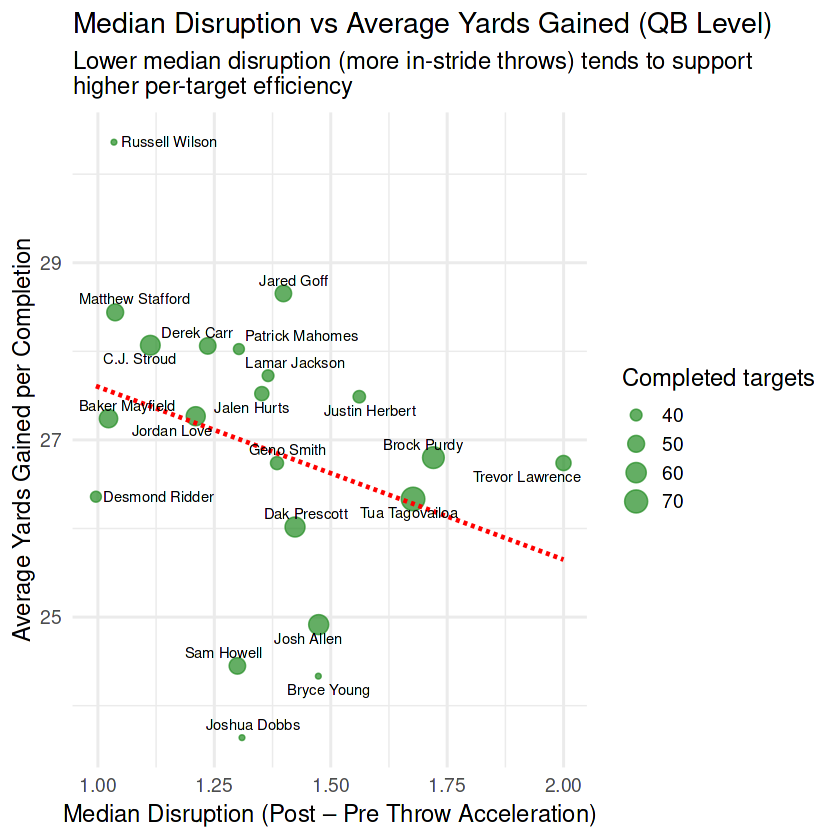

In [21]:
# ============================
# Disruption vs Average Yards Gained (QB Level)
# ============================

ggplot(qb_stride_scores,
       aes(x = median_disruption, y = avg_yards)) +
  geom_point(aes(size = n_targets),
             alpha = 0.7,
             color = "forestgreen") +
  geom_smooth(method = "lm",
              se = FALSE,
              linetype = "dashed",
              color = "red",
             formula = 'y ~ x') +
  geom_text_repel(aes(label = qb_name),
                  size = 3,
                  max.overlaps = 20) +
  scale_size_continuous(name = "Completed targets") +
  labs(
    title = "Median Disruption vs Average Yards Gained (QB Level)",
    subtitle = "Lower median disruption (more in-stride throws) tends to support\nhigher per-target efficiency",
    x = "Median Disruption (Post – Pre Throw Acceleration)",
    y = "Average Yards Gained per Completion"
  ) +
  theme_minimal(base_size = 14)

In [22]:
# ============================
# QB-level disruption vs EPA
# ============================

qb_stride_scores_epa <- stride_qb %>%
  drop_na(expected_points_added, disruption) %>%
  group_by(qb_id, qb_name) %>%
  summarise(
    n_targets         = n(),  # completed targets with disruption + EPA
    median_disruption = median(disruption_abs, na.rm = TRUE),
    avg_epa           = mean(expected_points_added, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  # keep QBs with a reasonable sample size
  filter(n_targets >= 35)

head(qb_stride_scores_epa)

qb_id,qb_name,n_targets,median_disruption,avg_epa
<int>,<chr>,<int>,<dbl>,<dbl>
34452,Matthew Stafford,50,1.037174,2.327637
38605,Russell Wilson,36,1.034520,2.444687
39987,Geno Smith,42,1.384608,2.168780
41265,Derek Carr,49,1.235884,2.599073
43290,Jared Goff,49,1.398347,2.163032
43424,Dak Prescott,59,1.423324,2.333553


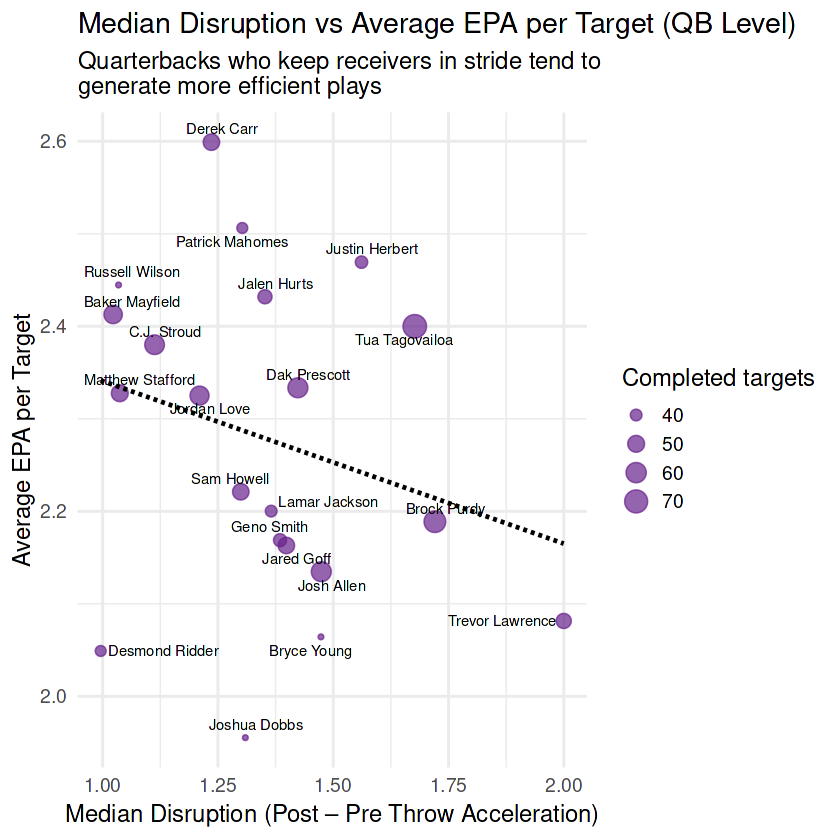

In [23]:
# ============================
# Median Disruption vs Average EPA (QB Level)
# ============================

ggplot(qb_stride_scores_epa,
       aes(x = median_disruption, y = avg_epa)) +
  geom_point(aes(size = n_targets),
             alpha = 0.7,
             color = "darkorchid4") +
  geom_smooth(method = "lm",
              se = FALSE,
              linetype = "dashed",
              color = "black",
             formula = 'y ~ x') +
  geom_text_repel(aes(label = qb_name),
                  size = 3,
                  max.overlaps = 20) +
  scale_size_continuous(name = "Completed targets") +
  labs(
    title = "Median Disruption vs Average EPA per Target (QB Level)",
    subtitle = "Quarterbacks who keep receivers in stride tend to\ngenerate more efficient plays",
    x = "Median Disruption (Post – Pre Throw Acceleration)",
    y = "Average EPA per Target"
  ) +
  theme_minimal(base_size = 14)

The plots above show the QBs who are the best at hitting their receivers in stride on deep passes. The top 5 quarterbacks were **Desmond Ridder, Baker Mayfield, Russell Wilson, Matthew Stafford, and C.J Stroud**. Other top quarterbacks, such as **Patrick Mahomes and Jalen Hurts**, also had better median disruption scores.

With both Yards per Completion and EPA, we can see a **relatively strong negative correlation** with median disruption. This indicates that having a lower disruption score is generally associated with **gaining more yards** and having **higher impact plays**. The more the QB forces the receiver to accelerate, the less successful the play.

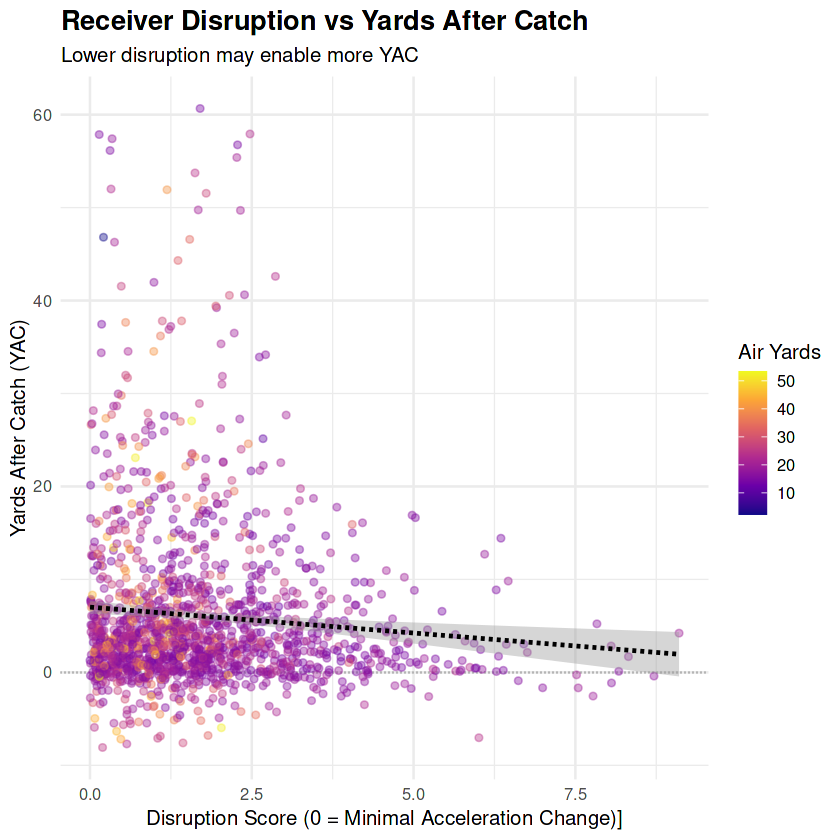

In [24]:
# ============================
# Visualize Disruption vs Yards After Catch (Play Level)
# ============================

# First, ensure we have the data with YAC calculated
stride_yac_plot <- stride_complete |>
  filter(!is.na(yards_after_catch), !is.na(disruption_abs), !is.na(air_yards))

# Create the plot
p_yac <- ggplot(stride_yac_plot, 
                aes(x = disruption_abs, y = yards_after_catch)) +
  geom_hline(yintercept = 0, linetype = "dotted", colour = "grey50") +
  geom_point(aes(color = air_yards), alpha = 0.4, size = 1.5) +
  geom_smooth(method = "lm", se = TRUE, color = "black", linetype = "dashed", 
              linewidth = 1, formula = y ~ x) +
  scale_color_viridis_c(option = "plasma", name = "Air Yards") +
  labs(
    title = "Receiver Disruption vs Yards After Catch",
    subtitle = "Lower disruption may enable more YAC",
    x = "Disruption Score (0 = Minimal Acceleration Change)]",
    y = "Yards After Catch (YAC)"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    plot.title = element_text(face = "bold", size = 16),
    legend.position = "right"
  )
print(p_yac)

Disruption score shows a negative correlation with yards after catch, showing that passes that keep a player in line with their current acceleration may lead to **1-3 yards of additional yardage** after the catch. Also, all plays with over 45 yards after the catch have a disruption score lower than 2.5. Thus, a low disruption score is critical for big playmaking after a reception.

## 🧠 Discussions and Implications for the Game

One implication on the game is assessing the connection quarterbacks have with their receivers. Certain quarterbacks have developed a connection with their receivers over many seasons, where they can predict their exact next movements. With this developed intuition, quarterbacks can more effectively hit their receivers in-stride, allowing for larger gains.

In [25]:
# ============================
# Calculate Catch Percentage for QB-Receiver Combinations
# ============================

# Get QB information
passers <- roles |>
  filter(player_role == "Passer", player_side == "Offense") |>
  distinct(
    game_id, play_id,
    qb_nfl_id = nfl_id,
    qb_name   = player_name
  )

# Get receiver information
receivers <- roles |>
  filter(player_position %in% c("WR", "TE", "RB")) |>
  distinct(nfl_id, receiver_name = player_name)

# Re-join QB and receiver info to stride_play_df to get all pass_results
stride_combo_full <- stride_play_df |>
  inner_join(passers, by = c("game_id", "play_id")) |>
  left_join(receivers, by = c("nfl_id")) |>
  rename(receiver_nfl_id = nfl_id) |>
  # Convert disruption to absolute value
  mutate(disruption_abs = abs(disruption))

# Aggregate by QB-Receiver combination to calculate catch percentage
catch_percentage_scores <- stride_combo_full |>
  group_by(qb_nfl_id, qb_name, receiver_nfl_id, receiver_name) |>
  summarise(
    total_targets            = n(),
    completed_passes         = sum(if_else(pass_result == "C", 1, 0), na.rm = TRUE),
    catch_percentage         = completed_passes / total_targets,
    avg_abs_disruption       = mean(disruption_abs, na.rm = TRUE),
    median_abs_disruption    = median(disruption_abs, na.rm = TRUE),
    .groups = "drop"
  ) |>
  # Filter to combinations with at least 15 targets for meaningful statistics
  filter(total_targets >= 25) |>
  arrange(desc(catch_percentage))


Top 10 QBs by Lowest Average Disruption (Best In-Stride):


# A tibble: 10 × 3
   qb_name          total_completed avg_disruption
   <chr>                      <dbl>          <dbl>
 1 Russell Wilson               179           2.05
 2 Baker Mayfield               271           2.07
 3 Joe Burrow                   130           2.11
 4 Matthew Stafford             245           2.14
 5 Jordan Love                  213           2.14
 6 Mac Jones                    134           2.16
 7 Aidan O'Connell              104           2.17
 8 Brock Purdy                  237           2.18
 9 Jared Goff                   303           2.21
10 Justin Fields                118           2.25


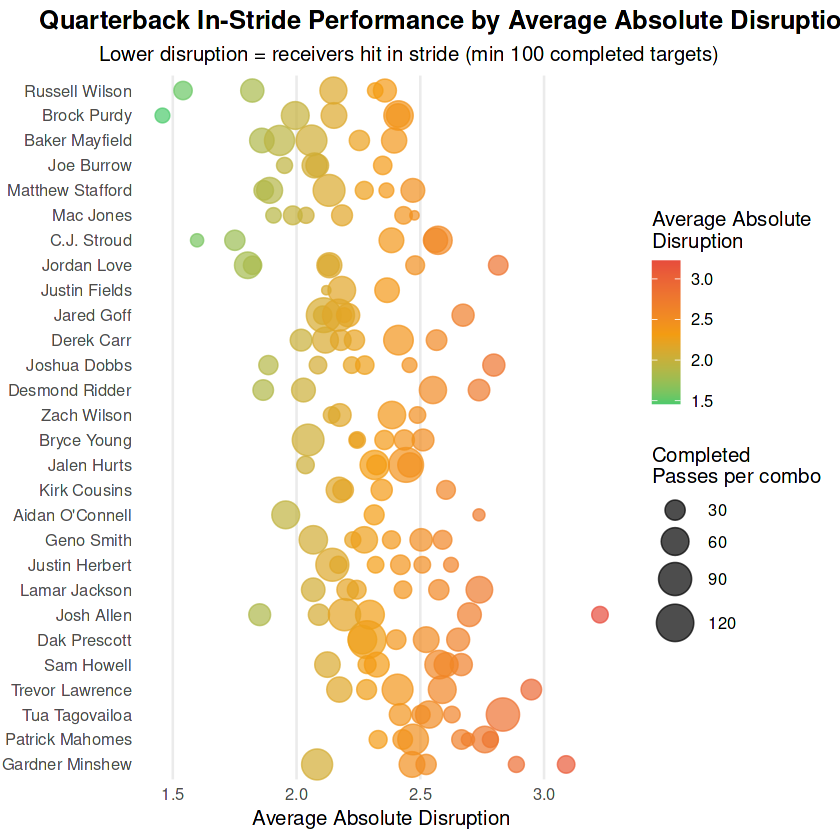

In [26]:
# Identify QBs with at least 100 total completed targets across all combinations
qbs_with_100_completed_targets <- catch_percentage_scores |>
  group_by(qb_nfl_id, qb_name) |>
  summarise(
    total_completed_targets = sum(completed_passes, na.rm = TRUE),
    .groups = "drop"
  ) |>
  filter(total_completed_targets >= 100) |>
  pull(qb_nfl_id)

# Filter catch_percentage_scores to include only combinations from these QBs
catch_scores_filtered_for_p1 <- catch_percentage_scores |>
  filter(qb_nfl_id %in% qbs_with_100_completed_targets)

# Enhanced QB In-Stride Score Visualization (p1)
# Lower avg_abs_disruption = better in-stride performance
p1 <- ggplot(catch_scores_filtered_for_p1,
       aes(x = avg_abs_disruption,
           y = reorder(qb_name, -avg_abs_disruption))) +  # Negative sign to put lowest disruption at top
  geom_point(aes(size = completed_passes, color = avg_abs_disruption), alpha = 0.7) +
  scale_color_gradient2(
    low = "#2ecc71",      # Green for low disruption (good)
    mid = "#f39c12",      # Orange for medium disruption
    high = "#e74c3c",     # Red for high disruption (bad)
    midpoint = median(catch_scores_filtered_for_p1$avg_abs_disruption),
    name = "Average Absolute\nDisruption"
  ) +
  scale_size_continuous(
    name = "Completed\nPasses per combo",
    range = c(2, 10)
  ) +
  labs(
    title = "Quarterback In-Stride Performance by Average Absolute Disruption",
    subtitle = "Lower disruption = receivers hit in stride (min 100 completed targets)",
    x = "Average Absolute Disruption",
    y = NULL
  ) +
  theme_minimal(base_size = 12) +
  theme(
    plot.title = element_text(face = "bold", size = 15, hjust = 0.3),
    plot.subtitle = element_text(hjust = 0.3),
    panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank()
  )

print(p1)

# Summary statistics for QBs with 100+ completed targets
qb_summary <- catch_scores_filtered_for_p1 |>
  group_by(qb_name) |>
  summarise(
    total_completed = sum(completed_passes),
    avg_disruption = weighted.mean(avg_abs_disruption, completed_passes), # use weighted mean to weight different qb-receiver combination by the number of passes
    .groups = "drop"
  ) |>
  arrange(avg_disruption)

cat("\nTop 10 QBs by Lowest Average Disruption (Best In-Stride):\n")
print(head(qb_summary, 10))

The average disruption varies across receiver even for the same quarterback. A lower disruption score indicates that the quarterback is effectively hitting that receiver in-stride allowing them to gain extra yards after the catch. A team could implement disruption score to indicate what receivers have and don't have chemistry with each other. 

In [27]:
# ============================
# Josh Allen QB-Receiver Disruption Table (with YAC)
# ============================

# First, calculate average YAC for each QB-receiver combo from stride_complete
qb_receiver_yac <- stride_complete |>
  inner_join(qb_roles, by = c("game_id", "play_id")) |>
  filter(!is.na(yards_after_catch)) |>
  group_by(qb_id, qb_name, nfl_id) |>
  summarise(
    avg_yac = mean(yards_after_catch, na.rm = TRUE),
    .groups = "drop"
  )

# Filter for Josh Allen's combinations and join with YAC data
josh_allen_combos <- catch_percentage_scores |>
  filter(qb_name == "Josh Allen") |>
  left_join(
    qb_receiver_yac |> filter(qb_name == "Josh Allen"),
    by = c("qb_nfl_id" = "qb_id", "receiver_nfl_id" = "nfl_id")
  ) |>
  arrange(avg_abs_disruption) |>  # Ascending order (lowest to highest)
  select(
    `Receiver` = receiver_name,
    `Total Targets` = total_targets,
    `Completed Passes` = completed_passes,
    `Catch %` = catch_percentage,
    `Avg Absolute Disruption` = avg_abs_disruption,
    `Avg Yards After Catch` = avg_yac
  )

# Create a formatted table with gt()
allen_table <- josh_allen_combos |>
  gt() |>
  tab_header(
    title = "Josh Allen: QB-Receiver Disruption Analysis",
    subtitle = "Sorted by Average Absolute Disruption (lowest to highest)"
  ) |>
  # Format catch percentage
  fmt_percent(
    columns = `Catch %`,
    decimals = 1
  ) |>
  # Format disruption to 2 decimal places
  fmt_number(
    columns = `Avg Absolute Disruption`,
    decimals = 2
  ) |>
  # Format YAC to 1 decimal place
  fmt_number(
    columns = `Avg Yards After Catch`,
    decimals = 1
  ) |>
  # Color scale for Average Absolute Disruption ONLY (matching plot colors)
  data_color(
    columns = `Avg Absolute Disruption`,
    fn = scales::col_numeric(
      palette = c("#2ecc71", "#f39c12", "#e74c3c"),  # Green -> Orange -> Red
      domain = NULL,
      reverse = FALSE  # Low values (green) to high values (red)
    )
  ) |>
  # Bold the disruption column header
  tab_style(
    style = cell_text(weight = "bold"),
    locations = cells_column_labels(columns = `Avg Absolute Disruption`)
  ) |>
  # Style the title
  tab_style(
    style = cell_text(weight = "bold", size = px(16)),
    locations = cells_title(groups = "title")
  ) |>
  # Add summary rows
  summary_rows(
    groups = NULL,
    columns = c(`Total Targets`, `Completed Passes`),
    fns = list(Total = ~sum(., na.rm = TRUE)),
    formatter = fmt_number,
    decimals = 0
  ) |>
  summary_rows(
    groups = NULL,
    columns = `Avg Absolute Disruption`,
    fns = list(`Weighted Avg` = ~weighted.mean(., w = josh_allen_combos$`Completed Passes`, na.rm = TRUE)),
    formatter = fmt_number,
    decimals = 2
  ) |>
  summary_rows(
    groups = NULL,
    columns = `Avg Yards After Catch`,
    fns = list(`Weighted Avg` = ~weighted.mean(., w = josh_allen_combos$`Completed Passes`, na.rm = TRUE)),
    formatter = fmt_number,
    decimals = 1
  )

# Display in notebook
display_html(as_raw_html(allen_table))

<table class="gt_table" data-quarto-disable-processing="false" data-quarto-bootstrap="false" style="-webkit-font-smoothing: antialiased; -moz-osx-font-smoothing: grayscale; font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji'; display: table; border-collapse: collapse; line-height: normal; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3;" bgcolor="#FFFFFF">
 
 
 Josh Allen: QB-Receiver Disruption Analysis 
 
 
 <td colspan="6" class="gt_heading gt_subtitle gt_font_normal gt_bottom_border" style="border-style: none; color: #333333; font-size: 85%; padding-top: 3px; padding-bottom: 5px; padding-left: 5px; padding-right: 5px; border-top-color: #FFFFFF; border-top-width: 0; background-color: #FFFFFF; text-align: center; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #D3D3D3; font-weight: normal;" bgcolor="#FFFFFF" align="center">Sorted by Average Absolute Disruption (lowest to highest) 
 
 
 <th class="gt_col_heading gt_columns_bottom_border gt_left" rowspan="1" colspan="1" scope="col" id="Receiver" style="border-style: none; color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: normal; text-transform: inherit; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: bottom; padding-top: 5px; padding-bottom: 6px; padding-left: 5px; padding-right: 5px; overflow-x: hidden; text-align: left;" bgcolor="#FFFFFF" valign="bottom" align="left">Receiver 
 <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="Total Targets" style="border-style: none; color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: normal; text-transform: inherit; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: bottom; padding-top: 5px; padding-bottom: 6px; padding-left: 5px; padding-right: 5px; overflow-x: hidden; text-align: right; font-variant-numeric: tabular-nums;" bgcolor="#FFFFFF" valign="bottom" align="right">Total Targets 
 <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="Completed Passes" style="border-style: none; color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: normal; text-transform: inherit; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: bottom; padding-top: 5px; padding-bottom: 6px; padding-left: 5px; padding-right: 5px; overflow-x: hidden; text-align: right; font-variant-numeric: tabular-nums;" bgcolor="#FFFFFF" valign="bottom" align="right">Completed Passes 
 <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="Catch %" style="border-style: none; color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: normal; text-transform: inherit; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: bottom; padding-top: 5px; padding-bottom: 6px; padding-left: 5px; padding-right

When looking at the disruption scores for Josh Allen, James Cook has the lowest average absolute disruption, indicating that Josh Allen has good chemistry with Cook in leading him forward through the catch. This allowed Cook to average 5 yards after the catch, while Knox, who has a high average absolute disruption, only averages 0.9 yards after the catch. This absolute disruption metric would allow a team, such as the Buffalo Bills, to identify receivers that don't have good connection with their quarterbacks and give them extra reps at practice to improve their connectivity. In this example, the Bills should give Davis and Knox extra reps in practice to improve the coordination with Allen and his receivers.

To truly show the importance of hitting the receiver in stride, we took a look at the longest reception of the 2023-24 season. On this play, Dak Prescott and the Cowboys were on offense against the Detroit Lions in Week 17. Prescott was under pressure and escaped the pocket, before launching it down the field towards star receiver CeeDee Lamb, with a defender on his back hip. Below we can see the player positions at the time of the throw, with Lamb (red circled receiver) in single coverage.

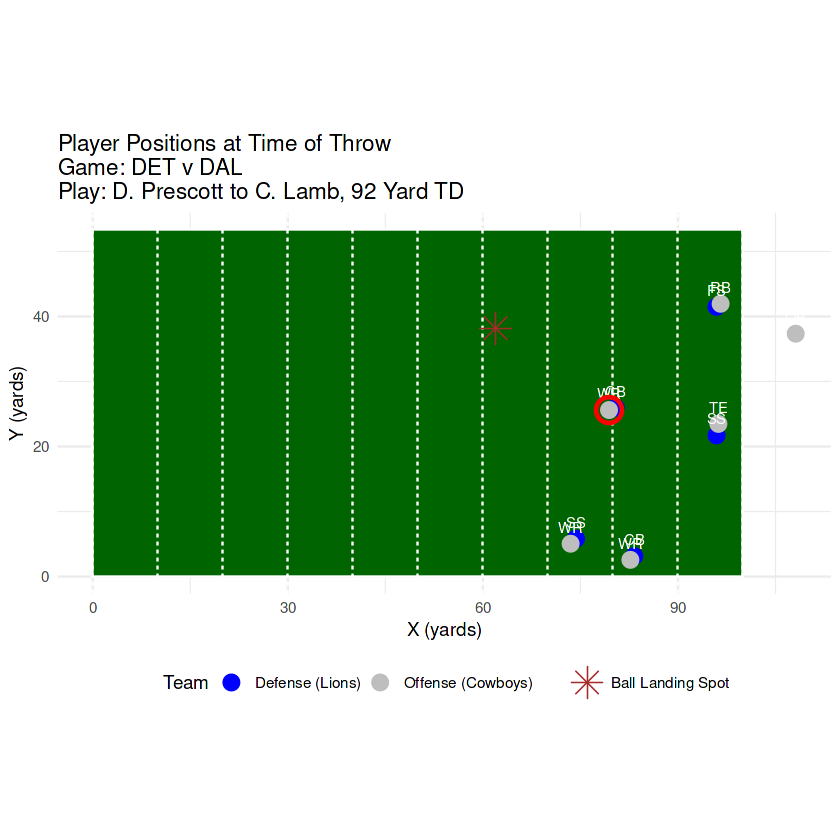

In [28]:
# ======================
# Plotting Biggest Play - Time of Throw
# ======================

target_game <- 2023123000
target_play <- 698

# Identify the throw frame (last input frame before release)
throw_frame <- df_input %>%
  filter(game_id == target_game, play_id == target_play) %>%
  slice_max(frame_id, n = 1) %>%
  pull(frame_id)

# All players at that frame
throw_positions <- df_input %>%
  filter(game_id == target_game, play_id == target_play, frame_id == throw_frame)
throw_positions <- throw_positions %>%
  mutate(player_side = case_when(
    player_side %in% c("Offense", "O", "Home") ~ "Offense (Cowboys)",
    player_side %in% c("Defense", "D", "Away") ~ "Defense (Lions)",
    TRUE ~ player_side
  ))

# Add marker column for ball landing spot
ball_land <- df_input %>%
  filter(game_id == target_game, play_id == target_play) %>%
  select(ball_land_x, ball_land_y) %>%
  distinct() %>%
  mutate(marker = "Ball Landing Spot")

ggplot() +
  # Field background
  geom_rect(aes(xmin = 0, xmax = 100, ymin = 0, ymax = 53.3),
            fill = "darkgreen", color = "white") +
  geom_vline(xintercept = seq(0, 100, by = 10),
             color = "white", linetype = "dashed") +
  
  # All players at throw, colored by side
  geom_point(data = throw_positions,
             aes(x = x, y = y, color = player_side), size = 4) +
  
  # Player position labels
  geom_text(data = throw_positions,
            aes(x = x, y = y, label = player_position),
            color = "white", size = 3, vjust = -1) +

  # Highlight targeted receiver (circle outline)
  geom_point(data = throw_positions %>% filter(player_role == "Targeted Receiver"),
             aes(x = x, y = y),
             color = "red", size = 6, shape = 1, stroke = 1.5) +
  
  # Ball landing spot (star, with legend entry)
  geom_point(data = ball_land,
             aes(x = ball_land_x, y = ball_land_y, shape = marker),
             color = "brown", size = 6) +
  
  # Custom scales
  scale_color_manual(values = c("Offense (Cowboys)" = "gray", "Defense (Lions)" = "blue")) +
  scale_shape_manual(values = c("Ball Landing Spot" = 8)) +
  
  labs(color = "Team", shape = "") +
  coord_fixed() +
  labs(title = "Player Positions at Time of Throw\nGame: DET v DAL\nPlay: D. Prescott to C. Lamb, 92 Yard TD",
       x = "X (yards)", y = "Y (yards)") +
  theme_minimal() +
  theme(legend.position = "bottom")

Then, we can watch the WR/DB battle play out. Lamb **hardly has to break stride** as he fights towards the ball landing spot. The perfectly placed throw allows Lamb to **catch the ball out in front of him**, with the defender on his hip, and break free for a **92 yard touchdown reception**.

The defender was on Lamb's back hip, so if that ball is underthrown at all and Lamb has to slow down, the play is likely broken up. Instead, Lamb is able to beat his defender, leaving him on the floor as he desperately tries to defend the perfect pass.

In [29]:
# ======================
# Plotting Biggest Play - Post-Throw Animation
# ======================

# --- Build metadata once ---
player_meta <- df_input %>%
  filter(game_id == target_game, play_id == target_play) %>%
  select(nfl_id, player_role, player_position, player_side) %>%
  distinct()

output_play <- df_output %>%
  filter(game_id == target_game, play_id == target_play) %>%
  left_join(player_meta, by = "nfl_id") %>%
  mutate(player_side = case_when(
    player_side %in% c("Offense", "O", "Home") ~ "Offense (Cowboys)",
    player_side %in% c("Defense", "D", "Away") ~ "Defense (Bills)",
    TRUE ~ player_side
  ))


ball_land <- df_input %>%
  filter(game_id == target_game, play_id == target_play) %>%
  select(ball_land_x, ball_land_y) %>%
  distinct() %>%
  mutate(marker = "Ball Landing Spot")   # for legend

# --- Generate frames ---
frames <- list()
for (f in sort(unique(output_play$frame_id))) {
  frame_data <- output_play %>% filter(frame_id == f)
  
  p <- ggplot() +
    # Field background
    annotate("rect", xmin = 0, xmax = 100, ymin = 0, ymax = 53.3,
             fill = "darkgreen", color = "white") +
    geom_vline(xintercept = seq(0, 100, by = 10),
               color = "white", linetype = "dashed") +
    
    # Players (offense/defense)
    geom_point(data = frame_data,
               aes(x = x, y = y, color = player_side), size = 4) +
    geom_text(data = frame_data,
              aes(x = x, y = y, label = player_position),
              color = "white", size = 3, vjust = -1) +
    
    # Targeted receiver highlight
    geom_point(data = frame_data %>% filter(player_role == "Targeted Receiver"),
               aes(x = x, y = y), color = "red", size = 6, shape = 1, stroke = 1.5) +

    # Ball landing spot (star, with legend)
    geom_point(data = ball_land,
               aes(x = ball_land_x, y = ball_land_y, shape = marker),
               color = "brown", size = 6) +
    
    # Custom scales
    scale_color_manual(values = c("Offense (Cowboys)" = "gray", "Defense (Bills)" = "blue")) +
    scale_shape_manual(values = c("Ball Landing Spot" = 8)) +
    
    labs(color = "Team", shape = "") +
    coord_fixed() +
    labs(title = paste("Player Movement After Throw\nFrame:", f),
         x = "X (yards)", y = "Y (yards)") +
    theme_minimal() +
    theme(legend.position = "bottom")
  
  img <- image_graph(width = 800, height = 400, res = 96)
  print(p)
  dev.off()
  frames[[length(frames) + 1]] <- img
}

# --- Stitch into GIF ---
animation <- image_join(frames)
animation <- image_animate(animation, fps = 10)  # slowed down

# Save to file
image_write(animation, path = "player_movement.gif", format = "gif")

# Display inline in Kaggle notebook
display_html('<img src="player_movement.gif" />')

Our results show that minimizing disruption, or how much a receiver accelerates or decelerates at the moment of the catch, is strongly tied to offensive success. Plays where the targeted receiver is able maintains stride are far more likely to generate explosive gains and higher EPA. 

Across the league, this pattern is consistent, when quarterbacks deliver the ball on-time and in rhythm and allow receivers to maintain their acceleration, offenses produce both more explosive plays and more efficient outcomes. These findings reinforce long-held coaching intuition about timing and rhythm, but provide a quantitative framework to evaluate ball placement and QB–WR connection.

## ⚠️ Limitations and Future Works

Th main limitation of this analysis is that it focuses only on completed passes, meaning disruption was not evaluated on targets that resulted in incompletions. This means certain difficult or mistimed incompletions may inflate a quarterback’s disruption score simply because those plays are excluded from the metric. Future projects could incorporate incompletions and even model completion probability to contextualize disruption. Additionally, the study examines only a single NFL season. It would be interesting to see whether disruption stabilizes for quarterbacks year over year, or whether it is more reflective improverment/regression, receiver traits, or scheme.

Additionally, this disruption metric does not take into account the level of pressure applied to the quarterback or coverage of the receiver. Both of these elements of defensive pressure could lead to errant throws or route adjustments that may significantly impact the receiver's running speed.

## 📚 References and Reproducibility

This notebook is fully reproducible using the publicly available data from the NFL Big Data Bowl 2026 Analytics competition on Kaggle. The notebook draws on the competition’s data dictionary, NFL Next Gen Stats documentation, and course guidance from Dr. Liz Wanless and Dr. Geoffre Sherman. Prior Big Data Bowl submissions were use to define the structure and presentation of the analysis. ChatGPT, Microsoft Copilot, and Claude were used for code verification and visualization assistance.